In [42]:
%matplotlib inline

In [43]:
# PUll in the libraries and define the functions we will be using

In [132]:
import os
import numpy as np
import matplotlib.pyplot as plt

def getChannelData(iChannel, strTestCase):
    cwd = os.getcwd()
    cwd = cwd+'\\TrainingData\\'+strTestCase

    f = []
    for (dirpath, dirnames, filenames) in os.walk(cwd):
        f.extend(filenames)
        break
        
    strFileSearch = 'Trace0' + str(iChannel)
    strFiles = filter(lambda x:strFileSearch in x, f)
    
    
    for idx in range(0, len(strFiles)):
        fh = open(cwd+'\\'+strFiles[idx], 'rb')
        # read the data into numpy
        if(idx==0):
            x = np.fromfile(fh, dtype=('>f'))
        else:
            x = np.append(x, np.fromfile(fh, dtype=('>f')))
        fh.close()
    
    return (x,strFiles)
    

In [133]:
# Begin by getting the data into python

['Trace01_0000000.dat']

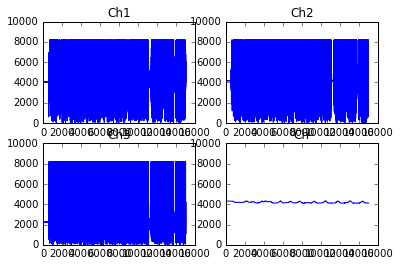

In [143]:
strFolder = 'Cobble1'
(x1,strFiles1) = getChannelData(1,strFolder)
(x2,strFiles2) = getChannelData(2,strFolder)
(x3,strFiles3) = getChannelData(3,strFolder)
(x4,strFiles4) = getChannelData(4,strFolder)
plt.subplot(2,2,1)
plt.plot(x1)
plt.ylim((0, 10000))
plt.title('Ch1')

plt.subplot(2,2,2)
plt.plot(x2)
plt.ylim((0, 10000))
plt.title('Ch2')

plt.subplot(2,2,3)
plt.plot(x3)
plt.ylim((0, 10000))
plt.title('Ch3')

plt.subplot(2,2,4)
plt.plot(x4)
plt.ylim((0, 10000))
plt.title('Ch')


strFiles1

In [144]:
x1

array([ 4080.,  4081.,  4084., ...,  4390.,  6756.,  4070.], dtype=float32)

In [145]:
x2

array([ 4178.,  4181.,  4188., ...,  6593.,  3431.,  3815.], dtype=float32)

In [146]:
x3

array([ 2237.,  2227.,  2239., ...,  1675.,  1024.,  4210.], dtype=float32)

In [147]:
x4

array([ 4301.,  4301.,  4301., ...,  4130.,  4128.,  4126.], dtype=float32)

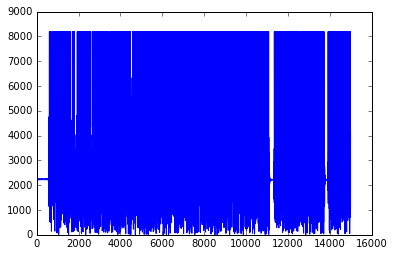

In [148]:
plt.plot(x3)

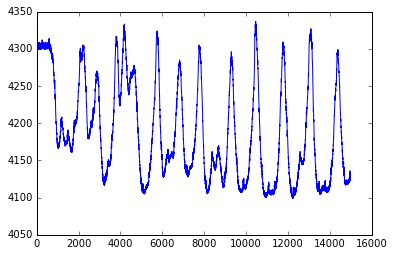

In [149]:
plt.plot(x4)